In [1]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

# load data

In [2]:
cwd=os.getcwd()

path_adjusted_temp=os.path.join(cwd, '../temperature/adjusted_ninja_temperature/')
path_preprocess_temp=os.path.join(cwd, '../temperature/')

threshold_path=os.path.join(cwd, '../../raw_data/threshold/')

df_theta=pd.read_csv(os.path.join(threshold_path, 'theta.csv'), index_col=[1], skiprows=1)
df_gas_threshold=pd.read_csv(os.path.join(threshold_path, 'gas_threshold.csv'), index_col=[1], skiprows=1)


# add FI, SE, LU, PT, CH, UA, NO gas threshold = 15 deg, the value used by Eurostat
df_gas_threshold=pd.concat([df_gas_threshold,
                           pd.DataFrame(index=['FI', 'SE', 'LU', 'PT', 'CH', 'UA', 'NO'], 
                                        columns=['country', 'threshold'],
                                       data=[['Finland', float(15.)], ['Sweden', float(15.)], 
                                             ['Luxembourg', float(15.)], ['Portugal', float(15.)],
                                             ['Switzerland', float(15.)], ['Ukraine', float(15.)],
                                             # for HDD analysis only; NO does not use gas for space heating
                                             ['Norway', float(15)]                                             
                                            ])], axis=0)
countries=list(df_gas_threshold.index)
df_gas_threshold

,country,threshold
AT,Austria,14.59
BE,Belgium,15.20
BG,Bulgaria,16.02
CZ,Czech Republic,14.80
DE,Germany,13.98
DK,Denmark,15.20
EE,Estonia,11.12
ES,Spain,18.47
FR,France,15.61
GB,Great Britain,14.18


In [3]:
# add summer start and end for LU and UA
df_theta.loc['LU']=['Luxembourg' , 6, 8]
df_theta.loc['UA']=['Ukraine', 5,9]
# put in same order
df_theta=df_theta.loc[countries]
df_theta[['summer_start', 'summer_end']]=df_theta[['summer_start', 'summer_end']].astype(int)
df_theta

,country,summer_start,summer_end
country_code,,,
AT,Austria,6,8
BE,Belgium,5,9
BG,Bulgaria,5,9
CZ,Czech Republic,6,8
DE,Germany,6,9
DK,Denmark,5,9
EE,Estonia,5,9
ES,Spain,4,10
FR,France,6,8


In [4]:
# load HDD error
df_HDD_error=pd.read_csv(os.path.join(path_preprocess_temp, 'ninja_temp_adjustment.csv'), index_col=0)
df_HDD_error=df_HDD_error[['annual_deviation']]
# add LU (modelled from BE and DE)
df_HDD_error.loc['LU', 'annual_deviation']=max(df_HDD_error.loc['BE', 'annual_deviation'],
                                              df_HDD_error.loc['DE', 'annual_deviation'])
# add UA (modelled from PL and RO)
df_HDD_error.loc['UA', 'annual_deviation']=max(df_HDD_error.loc['PL', 'annual_deviation'],
                                              df_HDD_error.loc['RO', 'annual_deviation'])
df_HDD_error=df_HDD_error.loc[countries]
df_HDD_error

,annual_deviation
AT,8.847375
BE,6.079521
BG,-7.506419
CZ,2.387805
DE,7.328643
DK,-2.526903
EE,-7.568004
ES,61.288233
FR,17.681582
GB,-1.706217


In [5]:
# pickle dump HDD-related model input dataframes
f = open('HDD_misc.pickle', 'wb')
pickle.dump((countries, df_gas_threshold, df_theta, df_HDD_error), f)
f.close()

# compute daily heating-degrees and annual heating degree days with different thresholds (+/-5 degrees)

In [6]:
# compute daily heating degree (HDD per day) for each country using different thresholds, taking into account heating season

dict_dfs_daily_HDD = dict() 

for country in countries:
#for country in ['GB']:
    
    threshold_baseline=df_gas_threshold.loc[country, 'threshold']
    summer_start=df_theta.loc[country, 'summer_start']
    summer_end=df_theta.loc[country, 'summer_end']
    
    # load temperature series
    _df_temp=pd.read_csv(os.path.join(path_adjusted_temp, 'adjusted_ninja_temp_%s.csv' %country))
    _df_temp['time']=pd.to_datetime(_df_temp['time'])
    _df_temp=_df_temp.set_index('time')
    
    # in steps of 0.5 deg, to 2 d.p.
    new_thresholds=np.round(np.linspace(threshold_baseline-5, threshold_baseline+5,21), 2) 
    
    v_temp=_df_temp['temperature']
    
    # df of heating degree-hours per hour
    _df_HDH=pd.DataFrame(index=_df_temp.index, columns=new_thresholds)
    
    for threshold in new_thresholds:
        _hourly_HD=(threshold - v_temp).clip(lower=0)
        _df_HDH[threshold]=_hourly_HD
    
    # HDH (and HDD) in summer months = 0
    _df_HDH.loc[(_df_HDH.index.month>=summer_start) & ((_df_HDH.index.month<=summer_end))]=0
    
    
    # df of heating degree-days per day
    df_daily_HDD=_df_HDH.groupby(_df_HDH.index.date).sum()/24 # divide by 24 to convert HDH to HDD
    df_daily_HDD.index=pd.to_datetime(df_daily_HDD.index)
    dict_dfs_daily_HDD[country]=df_daily_HDD
    
    
    print(country)
    
    

AT
BE
BG
CZ
DE
DK
EE
ES
FR
GB
GR
HR
HU
IE
IT
LT
LV
NL
PL
RO
SI
SK
FI
SE
LU
PT
CH
UA
NO


In [7]:
dict_dfs_daily_HDD['GB']

,9.18,9.68,10.18,10.68,11.18,11.68,12.18,12.68,13.18,13.68,...,14.68,15.18,15.68,16.18,16.68,17.18,17.68,18.18,18.68,19.18
1980-01-01,10.023247,10.523247,11.023247,11.523247,12.023247,12.523247,13.023247,13.523247,14.023247,14.523247,...,15.523247,16.023247,16.523247,17.023247,17.523247,18.023247,18.523247,19.023247,19.523247,20.023247
1980-01-02,10.659636,11.159636,11.659636,12.159636,12.659636,13.159636,13.659636,14.159636,14.659636,15.159636,...,16.159636,16.659636,17.159636,17.659636,18.159636,18.659636,19.159636,19.659636,20.159636,20.659636
1980-01-03,6.023536,6.523536,7.023536,7.523536,8.023536,8.523536,9.023536,9.523536,10.023536,10.523536,...,11.523536,12.023536,12.523536,13.023536,13.523536,14.023536,14.523536,15.023536,15.523536,16.023536
1980-01-04,3.682631,4.182631,4.682631,5.182631,5.682631,6.182631,6.682631,7.182631,7.682631,8.182631,...,9.182631,9.682631,10.182631,10.682631,11.182631,11.682631,12.182631,12.682631,13.182631,13.682631
1980-01-05,4.098170,4.598170,5.098170,5.598170,6.098170,6.598170,7.098170,7.598170,8.098170,8.598170,...,9.598170,10.098170,10.598170,11.098170,11.598170,12.098170,12.598170,13.098170,13.598170,14.098170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2.302024,2.802024,3.302024,3.802024,4.302024,4.802024,5.302024,5.802024,6.302024,6.802024,...,7.802024,8.302024,8.802024,9.302024,9.802024,10.302024,10.802024,11.302024,11.802024,12.302024
2019-12-28,1.021454,1.502791,2.002791,2.502791,3.002791,3.502791,4.002791,4.502791,5.002791,5.502791,...,6.502791,7.002791,7.502791,8.002791,8.502791,9.002791,9.502791,10.002791,10.502791,11.002791
2019-12-29,1.956432,2.456432,2.956432,3.456432,3.956432,4.456432,4.956432,5.456432,5.956432,6.456432,...,7.456432,7.956432,8.456432,8.956432,9.456432,9.956432,10.456432,10.956432,11.456432,11.956432
2019-12-30,2.522246,3.022246,3.522246,4.022246,4.522246,5.022246,5.522246,6.022246,6.522246,7.022246,...,8.022246,8.522246,9.022246,9.522246,10.022246,10.522246,11.022246,11.522246,12.022246,12.522246


In [8]:
# sum daily HDD to annual HDD
years=np.arange(1980, 2020)
df_annual_HDD_baseline=pd.DataFrame(index=years, columns=countries)

for country in countries:
    _threshold=df_gas_threshold.loc[country, 'threshold'] # use baseline threshold
    _df=dict_dfs_daily_HDD[country][_threshold]
    _v_annual_HDD=_df.groupby(_df.index.year).sum()
    df_annual_HDD_baseline[country]=_v_annual_HDD.values


df_annual_HDD_baseline
    

,AT,BE,BG,CZ,DE,DK,EE,ES,FR,GB,...,RO,SI,SK,FI,SE,LU,PT,CH,UA,NO
1980,2892.839050,2011.317810,2794.381499,2986.066674,2344.847410,2568.368114,2588.531070,1318.202086,2213.352464,1740.840433,...,2471.885711,2733.324561,2768.708531,4415.811105,3710.984566,2511.391697,663.238113,2622.140515,3048.689444,3736.199191
1981,2636.265930,1954.515665,2664.683099,2755.249091,2232.323489,2560.784260,2440.934547,1138.212553,2065.016430,1791.465968,...,2303.437919,2465.076672,2570.464297,4278.648505,3609.290772,2403.423005,544.379046,2678.674898,2674.711174,3698.685571
1982,2600.758398,1919.077897,2740.134050,2653.087120,2112.776851,2376.582923,2300.387182,1208.439243,1977.583874,1651.493969,...,2270.177406,2519.765732,2575.056395,4080.531246,3393.185366,2304.186974,605.802886,2416.039446,2722.846563,3431.577160
1983,2497.438358,1882.309344,2680.472968,2509.478682,2065.105083,2217.411350,2214.491634,1159.488418,2087.799894,1653.034719,...,2224.015285,2443.202573,2381.356203,3974.868569,3222.080480,2369.260288,584.795223,2507.895395,2507.724518,3272.269361
1984,2665.205201,1867.531958,2737.139305,2667.991524,2148.172232,2276.164069,2359.774730,1326.750793,2130.301903,1673.927795,...,2333.464577,2513.479374,2498.195706,3986.573818,3257.282816,2405.499302,655.554408,2592.905032,2796.441002,3398.927315
1985,2836.824154,2275.504807,2840.277256,2983.545118,2446.864992,2734.647472,2900.025208,1316.673720,2331.080961,1872.366303,...,2684.303324,2705.743024,2805.977211,4830.315420,4013.919967,2684.400618,650.807427,2712.721375,3195.332440,3914.070772
1986,2697.693629,2082.149760,2728.151321,2727.154859,2226.258365,2523.369553,2549.022737,1265.443599,2195.846735,1855.195754,...,2399.815196,2684.231547,2580.979568,4370.418344,3588.387869,2501.741975,642.356271,2575.989434,2800.084784,3656.585860
1987,2823.476021,2108.818373,2859.465635,2968.311869,2409.254167,2592.377028,2851.202464,1194.708309,2215.828164,1802.546034,...,2519.397764,2707.506256,2710.806028,4657.972280,3807.428241,2550.938209,570.894279,2587.036301,3265.459216,3705.388642
1988,2520.766415,1691.428434,2755.593266,2540.233329,1930.667530,2236.076344,2445.900424,1207.305040,1849.762181,1567.770786,...,2354.456381,2397.343904,2461.928518,4169.280050,3336.611127,2078.372431,605.497878,2485.294090,2842.986572,3412.328125
1989,2302.651268,1702.694601,2407.719616,2321.240960,1843.356326,1971.233570,1835.569968,1034.001586,1805.636247,1498.567015,...,2029.074157,2209.868316,2175.022811,3529.242102,2856.509870,2096.587583,498.062533,2238.609242,2285.228264,2973.392401


In [9]:
# pickle dump HDD with different thresholds
f = open('HDD_values.pickle', 'wb')
pickle.dump((dict_dfs_daily_HDD, df_annual_HDD_baseline), f)
f.close()

# mild, normal, hard year clustering based on annual baseline HDD

In [10]:
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from scipy import stats
from sklearn.preprocessing import MinMaxScaler

use 1D agglomerative model

for each country, we have 7 scenario years:

1, lowest annual HDD (mildest)
2, mild medoid (mild)
3, normal medoid (normal)
4, harsh medoid (hard)
5, highest annual HDD (hardest)
6, peak from 1980
7, peak from 2000

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance



df_medoid_year=pd.DataFrame(index=countries, columns=['mild', 'normal', 'hard'])
df_medoid_HDD=pd.DataFrame(index=countries, columns=['mild', 'normal', 'hard'])

dict_weather_year_clusters=dict()

for country in countries:
    
    _HDD=df_annual_HDD_baseline[country].values
        
    # agglomerative model
    _model = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(_HDD.reshape(-1,1))
    _cluster_labels=_model.labels_
    
    _years_clustered=[years[_cluster_labels==i] for i in range(3)]
    _HDD_clustered=[_HDD[_cluster_labels==i] for i in range(3)]
    
    # output clusters
    _order=np.array([_v_HDDs.mean() for _v_HDDs in _HDD_clustered]).argsort()
    dict_weather_year_clusters[country]={
        'mild':_years_clustered[np.where(_order==0)[0][0]],
        'normal':_years_clustered[np.where(_order==1)[0][0]],
        'hard':_years_clustered[np.where(_order==2)[0][0]]        
    }
    
    # find medoid
    _medoid_years=np.array([]).astype('int')
    _medoid_HDDs=np.array([]).astype('float')
    for i in range(3):
        _v=_HDD_clustered[i]
        _M_dist=distance.cdist(_v.reshape(-1,1), _v.reshape(-1,1))
        _sum_dist=_M_dist.sum(axis=1)
        _medoid_idx=_sum_dist.argmin()
        _medoid_year=_years_clustered[i][_medoid_idx]
        _medoid_HDD=_HDD_clustered[i][_medoid_idx]
        _medoid_years=np.append(_medoid_years, _medoid_year)
        _medoid_HDDs=np.append(_medoid_HDDs, _medoid_HDD)
    
    _medoid_years_sorted=_medoid_years[_medoid_HDDs.argsort()] # low to high
    _medoid_HDDs_sorted=np.sort(_medoid_HDDs) # low to high year
    
    df_medoid_year.loc[country]=_medoid_years_sorted
    df_medoid_HDD.loc[country]=_medoid_HDDs_sorted
    
df_medoid_year



,mild,normal,hard
AT,1994,1982,1985
BE,2002,1992,2010
BG,2014,1994,1984
CZ,2000,2013,1985
DE,2019,1999,1991
DK,1990,1991,1987
EE,2007,1998,1987
ES,2019,1988,1999
FR,2019,1982,1980
GB,2019,2012,1987


In [12]:
dict_weather_year_clusters


{'AT': {'mild': array([1989, 1990, 1994, 2000, 2002, 2007, 2008, 2011, 2014, 2015, 2016,
         2018, 2019]),
  'normal': array([1981, 1982, 1983, 1984, 1986, 1988, 1991, 1992, 1993, 1995, 1997,
         1998, 1999, 2001, 2003, 2004, 2005, 2006, 2009, 2012, 2013, 2017]),
  'hard': array([1980, 1985, 1987, 1996, 2010])},
 'BE': {'mild': array([1988, 1989, 1990, 1994, 1999, 2000, 2002, 2005, 2007, 2011, 2014,
         2015, 2017, 2018, 2019]),
  'normal': array([1980, 1981, 1982, 1983, 1984, 1991, 1992, 1993, 1995, 1997, 1998,
         2001, 2003, 2004, 2006, 2008, 2009, 2012, 2013, 2016]),
  'hard': array([1985, 1986, 1987, 1996, 2010])},
 'BG': {'mild': array([2014, 2019]),
  'normal': array([1989, 1990, 1994, 1999, 2000, 2001, 2002, 2004, 2006, 2007, 2008,
         2009, 2010, 2013, 2015, 2016, 2017, 2018]),
  'hard': array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1991, 1992,
         1993, 1995, 1996, 1997, 1998, 2003, 2005, 2011, 2012])},
 'CZ': {'mild': array([1980,

In [13]:
# table of mild, normal, hard categorisation 

df_cluster_summary=pd.DataFrame(index=countries, columns=years)
for country in countries:
    for cluster_label, cluster_years in dict_weather_year_clusters[country].items():
        df_cluster_summary.loc[country, list(dict_weather_year_clusters[country][cluster_label])]=cluster_label
        
df_cluster_summary

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
AT,hard,normal,normal,normal,normal,hard,normal,hard,normal,mild,...,hard,mild,normal,normal,mild,mild,mild,normal,mild,mild
BE,normal,normal,normal,normal,normal,hard,hard,hard,mild,mild,...,hard,mild,normal,normal,mild,mild,normal,mild,mild,mild
BG,hard,hard,hard,hard,hard,hard,hard,hard,hard,normal,...,normal,hard,hard,normal,mild,normal,normal,normal,normal,mild
CZ,mild,hard,hard,hard,hard,mild,hard,mild,hard,normal,...,mild,hard,hard,hard,normal,normal,hard,hard,normal,normal
DE,hard,hard,hard,hard,hard,hard,hard,hard,normal,normal,...,hard,normal,normal,hard,mild,mild,normal,normal,normal,mild
DK,mild,mild,hard,hard,hard,mild,mild,mild,hard,normal,...,mild,hard,hard,hard,normal,normal,hard,normal,hard,normal
EE,normal,normal,normal,mild,normal,hard,normal,hard,normal,mild,...,hard,mild,normal,normal,mild,mild,mild,mild,mild,mild
ES,normal,hard,mild,mild,normal,normal,normal,mild,mild,hard,...,normal,mild,normal,normal,hard,hard,hard,mild,mild,hard
FR,hard,normal,normal,normal,normal,hard,hard,hard,normal,mild,...,hard,mild,normal,normal,mild,mild,normal,normal,mild,mild
GB,hard,hard,normal,normal,normal,hard,hard,hard,normal,mild,...,hard,mild,normal,hard,mild,mild,normal,mild,normal,mild


In [14]:
# summary of size of each cluster for each country

df_cluster_cardinality=pd.DataFrame(index=countries, columns=['mild', 'normal', 'hard'])
for country in countries:
    df_cluster_cardinality.loc[country]=[dict_weather_year_clusters[country]['mild'].size,
          dict_weather_year_clusters[country]['normal'].size,
          dict_weather_year_clusters[country]['hard'].size]
df_cluster_cardinality=df_cluster_cardinality.astype(int)
df_cluster_cardinality

,mild,normal,hard
AT,13,22,5
BE,15,20,5
BG,2,18,20
CZ,5,8,27
DE,5,19,16
DK,7,9,24
EE,18,19,3
ES,18,11,11
FR,11,23,6
GB,17,15,8


In [15]:
df_medoid_HDD

,mild,normal,hard
AT,2312.29202,2600.758398,2836.824154
BE,1662.535606,1856.334156,2171.075853
BG,2202.369498,2416.925362,2737.139305
CZ,2268.31488,2622.694945,2983.545118
DE,1751.967503,1943.23,2193.432783
DK,1936.223935,2230.517047,2592.377028
EE,2057.156521,2431.658543,2851.202464
ES,1097.626298,1207.30504,1309.602995
FR,1775.995142,1977.583874,2213.352464
GB,1460.488531,1589.338415,1802.546034


In [16]:
# summary of all representative years

## add peak years

df_peak80=pd.read_csv(os.path.join(path_preprocess_temp, 'peak_years_80to19.csv'), index_col=0)
df_peak00=pd.read_csv(os.path.join(path_preprocess_temp, 'peak_years_00to19.csv'), index_col=0)

df_representative_year=df_medoid_year.copy()
df_representative_year['mildest']=df_annual_HDD_baseline.idxmin()
df_representative_year['hardest']=df_annual_HDD_baseline.idxmax()
df_representative_year['peak80']=df_peak80.loc[countries, 'coldest_year']
df_representative_year['peak00']=df_peak00.loc[countries, 'coldest_year']

df_representative_year=df_representative_year[['mildest', 'mild','normal','hard','hardest','peak80', 'peak00']]
df_representative_year


,mildest,mild,normal,hard,hardest,peak80,peak00
AT,2014,1994,1982,1985,1996,1985,2012
BE,2014,2002,1992,2010,1985,1987,2012
BG,2019,2014,1994,1984,2003,2012,2012
CZ,2014,2000,2013,1985,1996,1996,2006
DE,2014,2019,1999,1991,1996,1987,2012
DK,2014,1990,1991,1987,2010,1987,2012
EE,2015,2007,1998,1987,1985,1987,2011
ES,1989,2019,1988,1999,2005,1985,2012
FR,2014,2019,1982,1980,1985,1985,2012
GB,2014,2019,2012,1987,2010,1982,2010


In [17]:
df_representative_year.nunique(axis=1) # check degeneracy

AT    6
BE    7
BG    6
CZ    6
DE    7
DK    6
EE    6
ES    7
FR    6
GB    6
GR    7
HR    6
HU    6
IE    5
IT    7
LT    6
LV    7
NL    7
PL    6
RO    6
SI    6
SK    6
FI    7
SE    6
LU    7
PT    7
CH    7
UA    6
NO    6
dtype: int64

In [18]:
df_representative_year_HDD=df_medoid_HDD.copy()
df_representative_year_HDD['mildest']=df_annual_HDD_baseline.min()
df_representative_year_HDD['hardest']=df_annual_HDD_baseline.max()
df_representative_year_HDD['peak']=0
for country in countries:
    peak_year80=df_peak80.loc[country, 'coldest_year']
    peak_year00=df_peak00.loc[country, 'coldest_year']

    df_representative_year_HDD.loc[country, 'peak80']=df_annual_HDD_baseline.loc[peak_year80, country]
    df_representative_year_HDD.loc[country, 'peak00']=df_annual_HDD_baseline.loc[peak_year00, country]

df_representative_year_HDD=df_representative_year_HDD[['mildest', 'mild','normal','hard','hardest','peak80', 'peak00']]
df_representative_year_HDD

,mildest,mild,normal,hard,hardest,peak80,peak00
AT,2050.550596,2312.29202,2600.758398,2836.824154,2964.161576,2836.824154,2505.560326
BE,1471.272407,1662.535606,1856.334156,2171.075853,2275.504807,2108.818373,1813.175728
BG,2126.906415,2202.369498,2416.925362,2737.139305,2878.822651,2645.925425,2645.925425
CZ,2032.062055,2268.31488,2622.694945,2983.545118,3163.149685,3163.149685,2641.764064
DE,1597.201119,1751.967503,1943.23,2193.432783,2482.374308,2409.254167,2012.031465
DK,1838.684936,1936.223935,2230.517047,2592.377028,2762.429719,2592.377028,2291.549522
EE,1770.125968,2057.156521,2431.658543,2851.202464,2900.025208,2851.202464,2177.781529
ES,1034.001586,1097.626298,1207.30504,1309.602995,1388.678070,1316.673720,1266.142081
FR,1621.293340,1775.995142,1977.583874,2213.352464,2331.080961,2331.080961,1969.295931
GB,1313.235242,1460.488531,1589.338415,1802.546034,1924.155309,1651.493969,1924.155309


# choose a 10-year window for the model

In [19]:
# table of categorisation for all 40 years

df_year_categorisation=df_cluster_summary.copy()
for country in countries:
    for scenario in ['mildest', 'hardest', 'peak80', 'peak00']:
        scenario_year = df_representative_year.loc[country, scenario]
        df_year_categorisation.loc[country, scenario_year]=scenario


df_year_categorisation

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
AT,hard,normal,normal,normal,normal,peak80,normal,hard,normal,mild,...,hard,mild,peak00,normal,mildest,mild,mild,normal,mild,mild
BE,normal,normal,normal,normal,normal,hardest,hard,peak80,mild,mild,...,hard,mild,peak00,normal,mildest,mild,normal,mild,mild,mild
BG,hard,hard,hard,hard,hard,hard,hard,hard,hard,normal,...,normal,hard,peak00,normal,mild,normal,normal,normal,normal,mildest
CZ,mild,hard,hard,hard,hard,mild,hard,mild,hard,normal,...,mild,hard,hard,hard,mildest,normal,hard,hard,normal,normal
DE,hard,hard,hard,hard,hard,hard,hard,peak80,normal,normal,...,hard,normal,peak00,hard,mildest,mild,normal,normal,normal,mild
DK,mild,mild,hard,hard,hard,mild,mild,peak80,hard,normal,...,hardest,hard,peak00,hard,mildest,normal,hard,normal,hard,normal
EE,normal,normal,normal,mild,normal,hardest,normal,peak80,normal,mild,...,hard,peak00,normal,normal,mild,mildest,mild,mild,mild,mild
ES,normal,hard,mild,mild,normal,peak80,normal,mild,mild,mildest,...,normal,mild,peak00,normal,hard,hard,hard,mild,mild,hard
FR,hard,normal,normal,normal,normal,peak80,hard,hard,normal,mild,...,hard,mild,peak00,normal,mildest,mild,normal,normal,mild,mild
GB,hard,hard,peak80,normal,normal,hard,hard,hard,normal,mild,...,peak00,mild,normal,hard,mildest,mild,normal,mild,normal,mild


In [20]:
# convert to scores
df_year_categorisation_score=df_year_categorisation.replace({'mildest':0, 'mild':1, 'normal':2, 'hard':3, 'hardest':4, 
                                            'peak80':5, 'peak00':5})

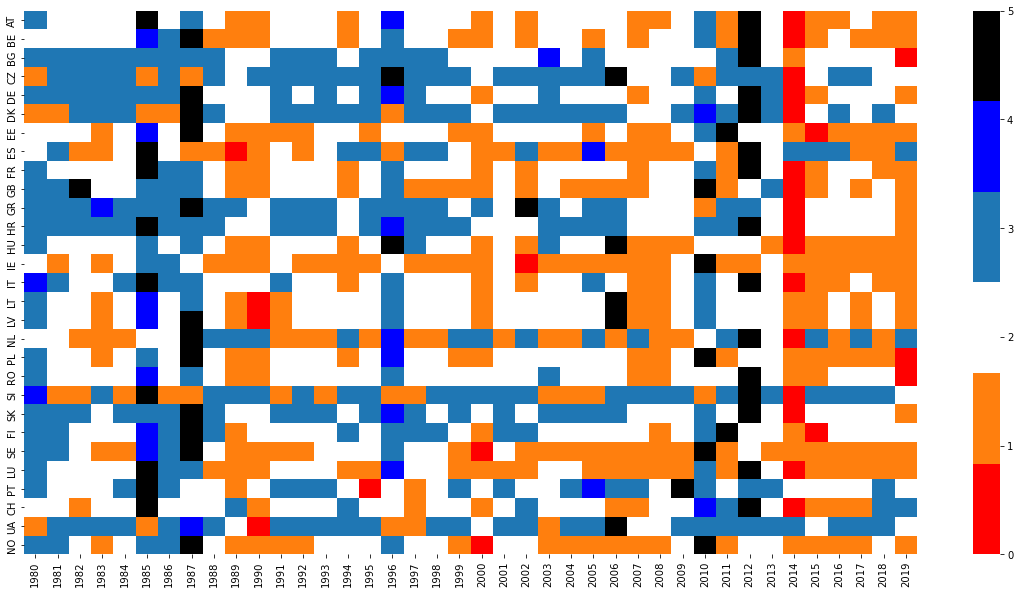

In [21]:
# visualise df_year_categorisation with a heatmap

import seaborn as sns
import matplotlib as mpl

plt.figure(figsize=(20,10))
cmap = (mpl.colors.ListedColormap(['red', 'tab:orange', 'white', 'tab:blue', 'blue', 'black'])
        .with_extremes(over='0.25', under='0.75'))

bounds = [-1, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sns.heatmap(df_year_categorisation_score, cmap=cmap)
plt.show()

In [22]:
# use sliding window to determine the 10-year window closest to the clustering distribution
dict_window_start={}

from scipy.spatial import distance

for country in countries:
    v_card=df_cluster_cardinality.loc[country].values/4
    
    # construct target vector --> add extra weight to extremes
    
    ## take one mild year out and substitute it with mildest if |mild|>=2
    if v_card[0]>=2:
        n_mildest=1
        n_mild=v_card[0]-1
    else:
        n_mildest=0
        n_mild=v_card[0]
        
    ## take two hard years out and substitute with hardest and peak if |hard|>=3
    if v_card[2]>=3:
        n_peak=1
        n_hardest=1
        n_hard=v_card[2]-2
    ## take one hard year out and substitute it with hardest if |hard|==2
    elif v_card[2]>=2:
        n_peak=0
        n_hardest=1
        n_hard=v_card[2]-1
    else:
        n_peak=0
        n_hardest=0
        n_hard=v_card[2]
        
    v_target=np.array([n_mildest, n_mild, v_card[1], n_hard, n_hardest, n_peak])
    print(country, v_target)
    
    # sliding window
    v_score=df_year_categorisation_score.loc[country]
    for s in range(40-10+1): # may have 40(|horizon|)-10(|window|)+1 steps
        # vector of scores in the window
        v_window = v_score[s:s+10]
        v_window_card=np.array([np.count_nonzero(v_window == v) for v in range(6)])
        #print(v_window_card.sum())
        
        # find the distance between the two distributions
        JS_dist=distance.jensenshannon(v_window_card, v_target)
        if s==0:
            v_dist=np.array([JS_dist])
        else:
            v_dist=np.append(v_dist, JS_dist)
    
    # find the optimum window
    s_optimum = np.argmin(v_dist)
    
    # output start year dictionary
    window_start=np.arange(1980, 2020, 1)[s_optimum]
    dict_window_start[country]=window_start
    #print(country, window_start)


AT [1.   2.25 5.5  1.25 0.   0.  ]
BE [1.   2.75 5.   1.25 0.   0.  ]
BG [0.  0.5 4.5 3.  1.  1. ]
CZ [0.   1.25 2.   4.75 1.   1.  ]
DE [0.   1.25 4.75 2.   1.   1.  ]
DK [0.   1.75 2.25 4.   1.   1.  ]
EE [1.   3.5  4.75 0.75 0.   0.  ]
ES [1.   3.5  2.75 1.75 1.   0.  ]
FR [1.   1.75 5.75 1.5  0.   0.  ]
GB [1.   3.25 3.75 1.   1.   0.  ]
GR [0.   0.75 3.5  3.75 1.   1.  ]
HR [0.  0.5 3.5 4.  1.  1. ]
HU [1.   2.75 4.75 1.5  0.   0.  ]
IE [1.   6.   2.25 0.75 0.   0.  ]
IT [1.  1.5 5.  1.5 1.  0. ]
LT [1.   1.75 6.   1.25 0.   0.  ]
LV [1.   1.75 6.   1.25 0.   0.  ]
NL [1.  3.5 2.  1.5 1.  1. ]
PL [1.   2.75 5.   1.25 0.   0.  ]
RO [0.   1.75 7.   1.25 0.   0.  ]
SI [1.   2.75 0.5  3.75 1.   1.  ]
SK [0.  0.5 4.  3.5 1.  1. ]
FI [0.   1.25 5.5  1.25 1.   1.  ]
SE [1.   5.   2.25 1.75 0.   0.  ]
LU [1.  4.5 3.  1.5 0.  0. ]
PT [0.   0.75 5.   2.25 1.   1.  ]
CH [1.   1.25 6.   1.75 0.   0.  ]
UA [0.   1.5  1.75 4.75 1.   1.  ]
NO [1.   3.75 3.5  1.75 0.   0.  ]


In [23]:
dict_window_start

{'AT': 1986,
 'BE': 1989,
 'BG': 2003,
 'CZ': 2001,
 'DE': 1996,
 'DK': 1982,
 'EE': 2006,
 'ES': 1986,
 'FR': 2005,
 'GB': 2007,
 'GR': 2002,
 'HR': 1993,
 'HU': 1985,
 'IE': 1993,
 'IT': 1991,
 'LT': 1986,
 'LV': 1988,
 'NL': 2005,
 'PL': 1981,
 'RO': 1986,
 'SI': 2005,
 'SK': 1987,
 'FI': 1982,
 'SE': 1996,
 'LU': 1986,
 'PT': 1981,
 'CH': 1986,
 'UA': 1998,
 'NO': 1996}

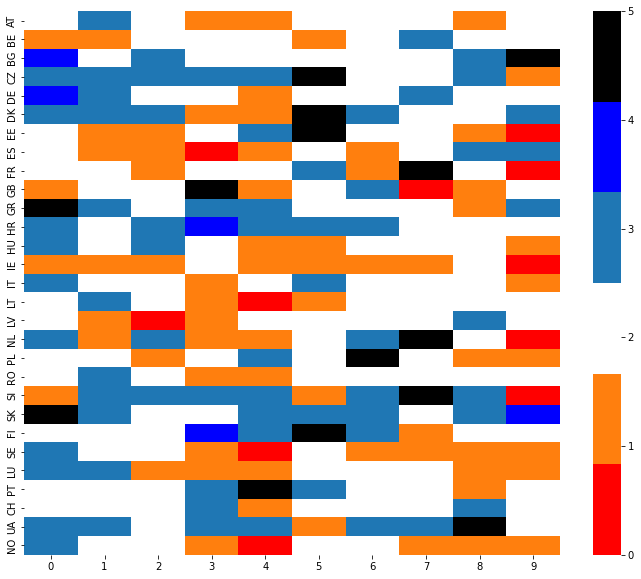

In [24]:
# visualise with a similar heatmap as above

M_windows=np.array([])

for country in countries:
    start_year=dict_window_start[country]
    v_scores=np.array([df_year_categorisation_score.loc[country, list(range(start_year, start_year+10))]])
    if M_windows.size==0:
        M_windows=np.array(v_scores)
    else:
        M_windows=np.concatenate([M_windows, v_scores], axis=0)
    
_df=pd.DataFrame(index=countries, columns=list(range(10)), data=M_windows)

plt.figure(figsize=(12,10))
cmap = (mpl.colors.ListedColormap(['red', 'tab:orange', 'white', 'tab:blue', 'blue', 'black'])
        .with_extremes(over='0.25', under='0.75'))

bounds = [-1, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sns.heatmap(_df, cmap=cmap)
plt.show()


In [25]:
# pickle dump
f = open('clustering.pickle', 'wb')
pickle.dump((df_cluster_summary, df_cluster_cardinality, df_representative_year, df_representative_year_HDD,
             dict_window_start), f)
f.close()